In [1]:
# config
run_analysis = False

In [2]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]
    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")

    # add sample weights, which are 1 for observed and 3 for estimated
    X_train_observed["sample_weight"] = 1
    X_train_estimated["sample_weight"] = 3
    X_test["sample_weight"] = 3

    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

    X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
    # the filled once will get dropped later anyways, when we drop y nans
    X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')


    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)

    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])

    # fill missng sample_weight with 3
    #X_train["sample_weight"] = X_train["sample_weight"].fillna(0)
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in sample_weight
    print(f"Number of nans in sample_weight: {X_train['sample_weight'].isna().sum()}")
    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Number of nans in sample_weight: 0
Number of nans in y: 0
Processing location B...
Number of nans in sample_weight: 0
Number of nans in y: 4
Processing location C...
Number of nans in sample_weight: 0
Number of nans in y: 6059


# Feature enginering

In [3]:
# temporary
X_train["hour"] = X_train.index.hour
X_train["weekday"] = X_train.index.weekday
# weekday or is_weekend
X_train["is_weekend"] = X_train["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# drop weekday
#X_train.drop(columns=["weekday"], inplace=True)
X_train["month"] = X_train.index.month
X_train["year"] = X_train.index.year

X_test["hour"] = X_test.index.hour
X_test["weekday"] = X_test.index.weekday

# weekday or is_weekend
X_test["is_weekend"] = X_test["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# drop weekday
#X_test.drop(columns=["weekday"], inplace=True)
X_test["month"] = X_test.index.month
X_test["year"] = X_test.index.year



to_drop = ["snow_drift:idx", "snow_density:kgm3"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.dropna(subset=['y'], inplace=True)
X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

In [4]:
import autogluon.eda.auto as auto

if run_analysis:
    auto.dataset_overview(train_data=X_train, test_data=X_test, label="y", sample=None)

In [5]:
if run_analysis:
    auto.target_analysis(train_data=X_train, label="y")

# Starting

In [6]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 78
Now creating submission number: 79
New filename: submission_79


In [7]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('X_train_raw.csv')
train_data.drop(columns=['ds'], inplace=True)

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60
presets = 'best_quality'

sample_weight = 'sample_weight' #None
weight_evaluation = True #False


In [8]:
predictors = [None, None, None]

In [9]:
loc = "A"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}", sample_weight=sample_weight, weight_evaluation=weight_evaluation).fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[0] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_79_A/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.3.0: Mon Jan 30 20:38:37 PST 2023; root:xnu-8792.81.3~2/RELEASE_ARM64_T6000
Disk Space Avail:   49.88 GB / 494.38 GB (10.1%)
Train Data Rows:    34061
Train Data Columns: 51
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 631.01116, 1166.20607)
	If 'r

Training model for location A...


	-277.2896	 = Validation score   (-mean_absolute_error)
	0.02s	 = Training   runtime
	0.85s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 38.92s of the 58.87s of remaining time.
	-278.2945	 = Validation score   (-mean_absolute_error)
	0.03s	 = Training   runtime
	0.79s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 38.05s of the 58.01s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-144.6382	 = Validation score   (-mean_absolute_error)
	31.83s	 = Training   runtime
	56.67s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 59.84s of the 16.76s of remaining time.
	-144.6382	 = Validation score   (-mean_absolute_error)
	0.16s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 16.59s of the 16.

In [ ]:

loc = "B"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}", sample_weight=sample_weight, weight_evaluation=weight_evaluation).fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[1] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_79_jorge_B/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   15.97 GB / 494.38 GB (3.2%)
Train Data Rows:    32819
Train Data Columns: 51
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 96.89334, 194.00409)
	If

Training model for location B...


	Not enough time to generate out-of-fold predictions for model. Estimated time required was 160.16s compared to 51.82s of available time.
	Time limit exceeded... Skipping KNeighborsUnif_BAG_L1.
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 37.4s of the 57.35s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 133.14s compared to 48.59s of available time.
	Time limit exceeded... Skipping KNeighborsDist_BAG_L1.
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 35.32s of the 55.28s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-23.1587	 = Validation score   (-mean_absolute_error)
	24.39s	 = Training   runtime
	65.15s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 0.11s of the 20.06s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-116.8768	 = Valid

In [ ]:
loc = "C"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}", sample_weight=sample_weight, weight_evaluation=weight_evaluation).fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[2] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20


Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation will report weighted metrics, so ensure same column exists in test data.
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_79_jorge_C/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   15.55 GB / 494.38 GB (3.1%)
Train Data Rows:    26071
Train Data Columns: 51
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 77.70004, 165.87752)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You

Training model for location C...


	Not enough time to generate out-of-fold predictions for model. Estimated time required was 105.14s compared to 51.84s of available time.
	Time limit exceeded... Skipping KNeighborsUnif_BAG_L1.
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 37.83s of the 57.79s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 57.03s compared to 49.15s of available time.
	Time limit exceeded... Skipping KNeighborsDist_BAG_L1.
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 36.69s of the 56.65s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-15.6035	 = Validation score   (-mean_absolute_error)
	19.08s	 = Training   runtime
	46.76s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 8.83s of the 28.79s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-17.042	 = Validat

# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 53 / 53 | Rows = 92951 -> 92951
Loaded data from: X_test_raw.csv | Columns = 52 / 52 | Rows = 2160 -> 2160


In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

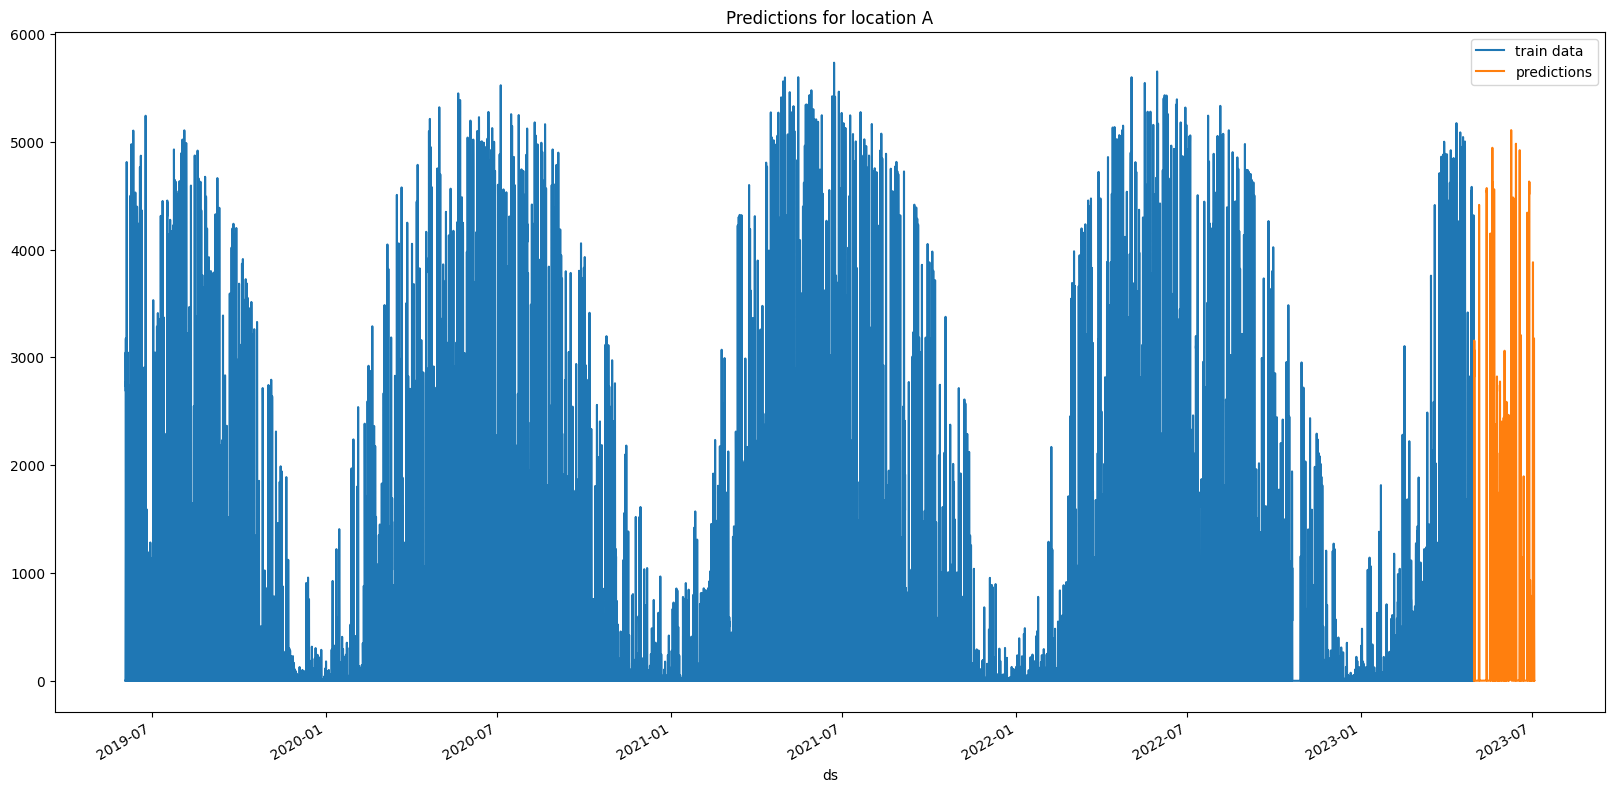

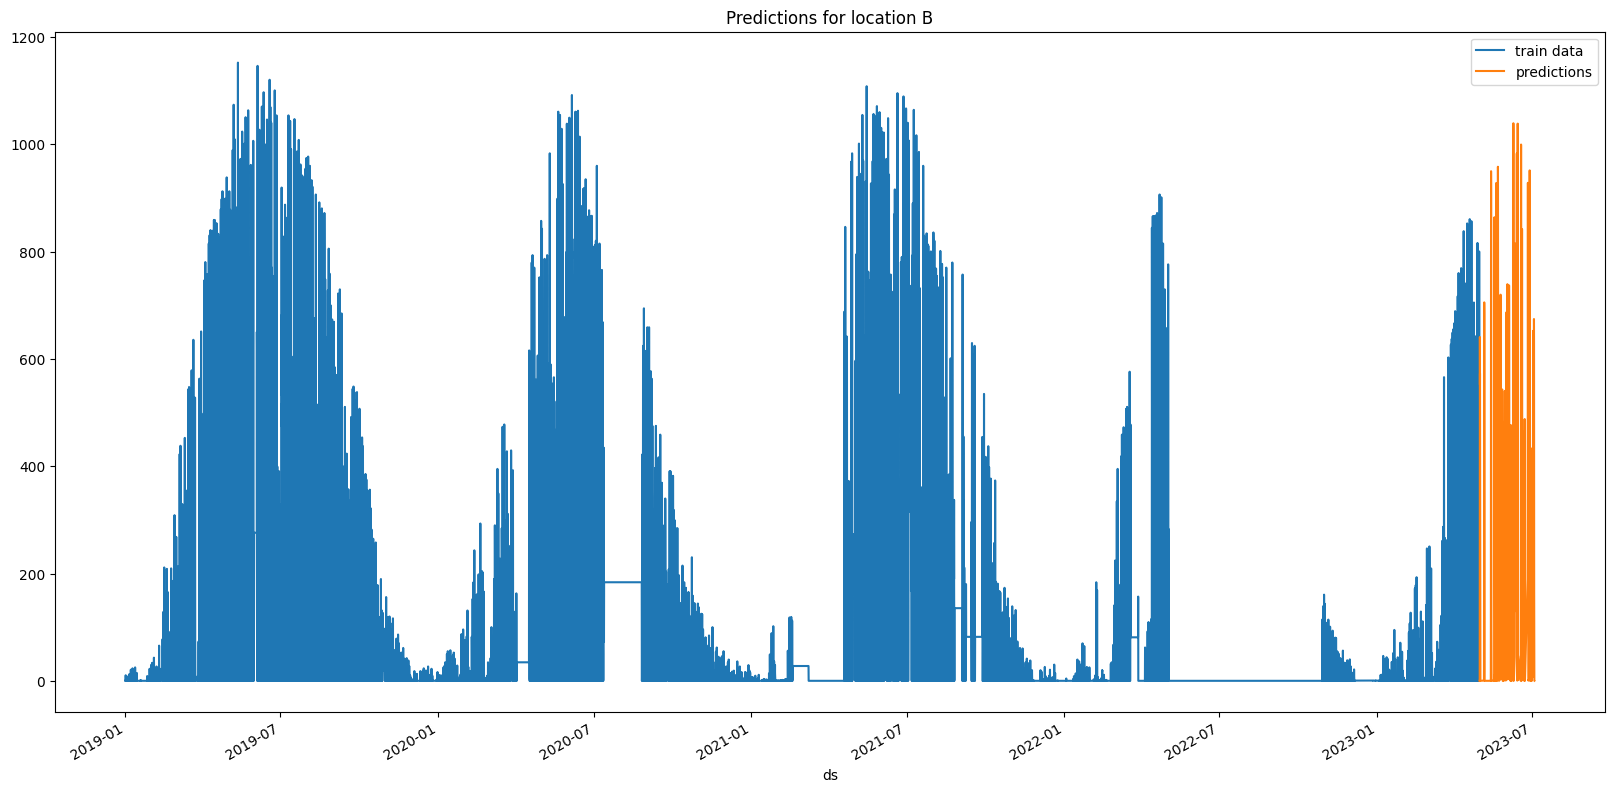

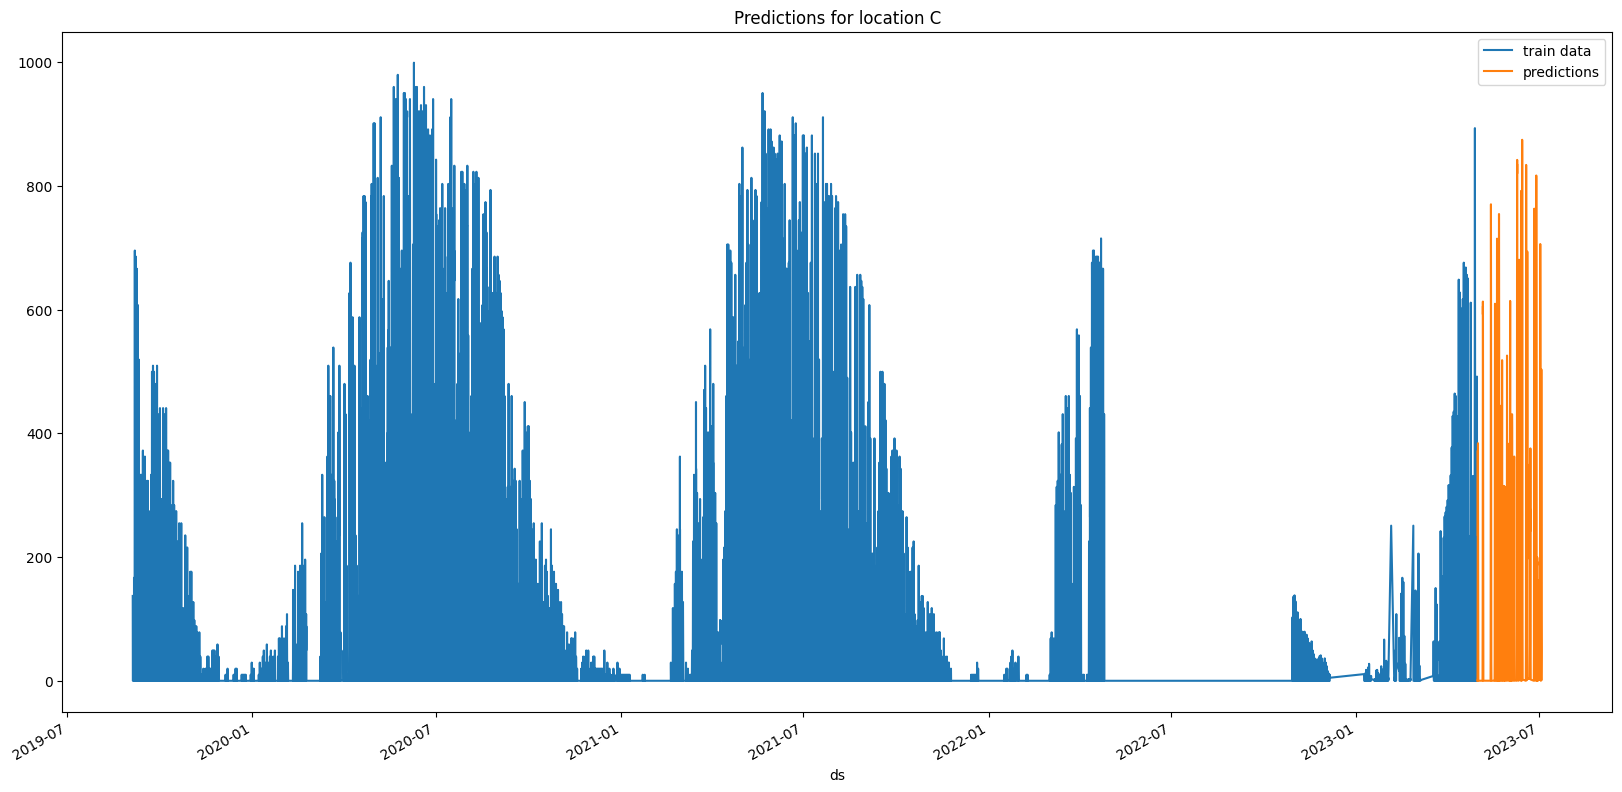

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

,id,prediction
0,0,1.353503
1,1,1.377337
2,2,1.535772
3,3,50.274967
4,4,298.462311
...,...,...
715,2155,91.790527
716,2156,58.327251
717,2157,25.278416
718,2158,3.892292


In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_79_jorge.csv


In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_79_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_79_jorge_files/notebook_pdfs
[NbConvertApp] Writing 152138 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1471956 bytes to notebook_pdfs/submission_79_jorge.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_79_jorge.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [ ]:
# feature importance
location="A"
split_time = pd.Timestamp("2022-10-28 22:00:00")
estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]
estimated = estimated[estimated["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=estimated, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'sample_weight', 'location']
Computing feature importance via permutation shuffling for 48 features using 4394 rows with 10 shuffle sets... Time limit: 600s...
	3094.63s	= Expected runtime (309.46s per shuffle set)
	419.07s	= Actual runtime (Completed 2 of 10 shuffle sets) (Early stopping due to lack of time...)


,importance,stddev,p_value,n,p99_high,p99_low
direct_rad:W,179.527752,0.089041,0.000112,2,183.535682,175.519822
clear_sky_rad:W,102.034121,0.763313,0.001684,2,136.392434,67.675808
diffuse_rad:W,76.319510,0.242082,0.000714,2,87.216140,65.422880
sun_elevation:d,48.306937,1.434587,0.006683,2,112.880735,-16.266861
hour,37.283222,0.841950,0.005082,2,75.181160,-0.614717
sun_azimuth:d,34.812837,0.901175,0.005826,2,75.376611,-5.750937
direct_rad_1h:J,28.456567,0.184929,0.001463,2,36.780617,20.132516
cloud_base_agl:m,23.171833,0.354225,0.003441,2,39.116231,7.227436
clear_sky_energy_1h:J,22.080754,0.614640,0.006264,2,49.747021,-5.585513
total_cloud_cover:p,21.249354,0.411635,0.004360,2,39.777903,2.720806


In [ ]:
# feature importance
observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]
observed = observed[observed["location"] == location]
predictor.feature_importance(feature_stage="original", data=observed, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'sample_weight', 'location']
Computing feature importance via permutation shuffling for 48 features using 5000 rows with 10 shuffle sets... Time limit: 600s...
	4293.33s	= Expected runtime (429.33s per shuffle set)
	359.81s	= Actual runtime (Completed 1 of 10 shuffle sets) (Early stopping due to lack of time...)


,importance,stddev,p_value,n,p99_high,p99_low
clear_sky_rad:W,34.800616,NaN,NaN,1,NaN,NaN
sun_elevation:d,21.053896,NaN,NaN,1,NaN,NaN
clear_sky_energy_1h:J,17.959037,NaN,NaN,1,NaN,NaN
direct_rad:W,15.484854,NaN,NaN,1,NaN,NaN
diffuse_rad:W,8.571135,NaN,NaN,1,NaN,NaN
direct_rad_1h:J,3.283643,NaN,NaN,1,NaN,NaN
relative_humidity_1000hPa:p,1.839748,NaN,NaN,1,NaN,NaN
sun_azimuth:d,1.549566,NaN,NaN,1,NaN,NaN
hour,0.997634,NaN,NaN,1,NaN,NaN
wind_speed_v_10m:ms,0.907447,NaN,NaN,1,NaN,NaN


In [ ]:
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_79_jorge_with_feature_importance_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_79_jorge_with_feature_importance_files/notebook_pdfs
[NbConvertApp] Writing 152954 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1471953 bytes to notebook_pdfs/submission_79_jorge_with_feature_importance.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_79_jorge_with_feature_importance.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [ ]:
import subprocess

def execute_git_command(directory, command):
    """Execute a Git command in the specified directory."""
    try:
        result = subprocess.check_output(['git', '-C', directory] + command, stderr=subprocess.STDOUT)
        return result.decode('utf-8').strip(), True
    except subprocess.CalledProcessError as e:
        print(f"Git command failed with message: {e.output.decode('utf-8').strip()}")
        return e.output.decode('utf-8').strip(), False

git_repo_path = "."

execute_git_command(git_repo_path, ['config', 'user.email', 'henrikskog01@gmail.com'])
execute_git_command(git_repo_path, ['config', 'user.name', hello if hello is not None else 'Henrik eller Jørgen'])

branch_name = new_filename

# add datetime to branch name
branch_name += f"_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}"

commit_msg = "run result"

execute_git_command(git_repo_path, ['checkout', '-b',branch_name])

# Navigate to your repo and commit changes
execute_git_command(git_repo_path, ['add', '.'])
execute_git_command(git_repo_path, ['commit', '-m',commit_msg])

# Push to remote
output, success = execute_git_command(git_repo_path, ['push', 'origin',branch_name])

# If the push fails, try setting an upstream branch and push again
if not success and 'upstream' in output:
    print("Attempting to set upstream and push again...")
    execute_git_command(git_repo_path, ['push', '--set-upstream', 'origin',branch_name])
    execute_git_command(git_repo_path, ['push', 'origin', 'henrik_branch'])

execute_git_command(git_repo_path, ['checkout', 'main'])

('Switched to branch \'main\'\nYour branch is behind \'origin/main\' by 2 commits, and can be fast-forwarded.\n  (use "git pull" to update your local branch)',
 True)